# Sentiment Expert Training (MULTI-SYMBOL) (DVC + MLflow)

This notebook trains a **sentiment-only** baseline expert using the **daily aggregated FinBERT features** produced by the news feature-build pipeline, and joins them with the OHLCV-derived label (`y_up_*d`).

Flow:
- Clone repo + `dvc pull` (reproducible dataset version)
- Load `news_sentiment_features.parquet` + OHLCV labels
- Apply the same metadata-driven date splits (from OHLCV metadata)
- TrainCV (TimeSeriesSplit) on TRAIN only, select via VAL, refit on TRAIN+VAL
- Log to MLflow + register model


In [1]:
# Install deps (Colab)
!pip -q install feast==0.58.0 s3fs boto3 pyarrow pandas scikit-learn "mlflow>=2.12,<3" "dagshub==0.6.4" "dvc[s3]" transformers torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.1/114.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.

## 1) Credentials / Environment
Set these using Colab `userdata` (or replace with your own method).

In [2]:
import os
from google.colab import userdata

# AWS
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_DEFAULT_REGION'] = userdata.get('AWS_DEFAULT_REGION') or 'us-east-1'

# MLflow (DAGsHub)
os.environ["DAGSHUB_USER_TOKEN"] = userdata.get('DAGSHUB_TOKEN')

missing = [k for k in ['AWS_ACCESS_KEY_ID','AWS_SECRET_ACCESS_KEY','DAGSHUB_USER_TOKEN'] if not os.environ.get(k)]
if missing:
    raise ValueError(f"Missing secrets in Colab userdata: {missing}")
print('Secrets loaded:', ', '.join(['AWS_ACCESS_KEY_ID','AWS_SECRET_ACCESS_KEY','AWS_DEFAULT_REGION','DAGSHUB_USER_TOKEN']))

Secrets loaded: AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_DEFAULT_REGION, DAGSHUB_USER_TOKEN


## 2) Clone repo + pull DVC dataset
This ensures `git_sha` and `.dvc` pointers exist locally, and that the dataset version is reproducible.

In [3]:
from pathlib import Path

REPO_NAME = "dissertation"  # change if needed
REPO_URL = f"https://github.com/Roncool13/{REPO_NAME}.git"
BRANCH_OR_COMMIT = "main"  # or a specific commit hash for perfect reproducibility

if not Path(REPO_NAME).exists():
    !git clone {REPO_URL}
%cd {REPO_NAME}
!git checkout {BRANCH_OR_COMMIT}

# Pull DVC-versioned dataset artifacts
!dvc pull data/features/ohlcv_features.parquet
!dvc pull data/features/ohlcv_feature_metadata.json
!dvc pull data/features/news_sentiment_features.parquet
!dvc pull data/features/news_sentiment_feature_metadata.json

%cd ..

Cloning into 'dissertation'...
remote: Enumerating objects: 992, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 992 (delta 68), reused 91 (delta 37), pack-reused 864 (from 1)
Receiving objects: 100% (992/992), 496.59 KiB | 5.71 MiB/s, done.
Resolving deltas: 100% (613/613), done.
/content/dissertation
Already on 'main'
Your branch is up to date with 'origin/main'.
Fetching
!
  0% |          |0/? [00:00<?,    ?files/s]
                                           
!
  0% |          |0/? [00:00<?,    ?files/s]
                                           
Fetching from s3:   0% 0/1 [00:00<?, ?file/s]
Fetching from s3:   0% 0/1 [00:00<?, ?file/s{'info': ''}]

  0% 0.00/17.4M [00:00<?, ?B/s]

  0% 0.00/17.4M [00:00<?, ?B/s{'info': ''}]

  4% 765k/17.4M [00:00<00:02, 7.83MB/s{'info': ''}]

 24% 4.22M/17.4M [00:00<00:00, 24.5MB/s{'info': ''}]

 87% 15.1M/17.4M [00:00<00:00, 65.2MB/s{'info': ''}]

                              

## 3) MLflow setup

In [4]:
import mlflow
import dagshub

dagshub.init(repo_owner='Roncool13', repo_name='dissertation-mlflow', mlflow=True)
mlflow.set_experiment("dissertation-sentiment-prediction-multisym-2019-23")
mlflow.sklearn.autolog(disable=True)

print('MLflow tracking URI:', mlflow.get_tracking_uri())

Accessing as Roncool13

Initialized MLflow to track repo "Roncool13/dissertation-mlflow"

Repository Roncool13/dissertation-mlflow initialized!

MLflow tracking URI: https://dagshub.com/Roncool13/dissertation-mlflow.mlflow


## 4) Reproducibility + dataset lineage logging (Git + DVC)

In [5]:
import subprocess
import hashlib
import json
import numpy as np
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

def _run(cmd):
    return subprocess.check_output(cmd, text=True).strip()

def _sha256_file(path):
    h = hashlib.sha256()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(1024*1024), b''):
            h.update(chunk)
    return h.hexdigest()

def log_code_and_data_version():
    # Git commit
    try:
        mlflow.set_tag('git_sha', _run(['git','rev-parse','HEAD']))
    except Exception:
        mlflow.set_tag('git_sha', 'unavailable')

    # DVC pointer hashes (these change when the dataset changes)
    for tag, p in [
        ('dvc_ptr_features_sha256', f'{REPO_NAME}/data/features/ohlcv_features.parquet.dvc'),
        ('dvc_ptr_metadata_sha256', f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json.dvc'),
    ]:
        try:
            mlflow.set_tag(tag, _sha256_file(p))
        except Exception:
            mlflow.set_tag(tag, 'unavailable')

    # Log pointer files + metadata as artifacts (small, very useful)
    for p, ap in [
        (f'{REPO_NAME}/data/features/ohlcv_features.parquet.dvc', 'dataset_pointers'),
        (f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json.dvc', 'dataset_pointers'),
        (f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json', 'dataset_metadata'),
    ]:
        try:
            mlflow.log_artifact(p, artifact_path=ap)
        except Exception:
            pass

    # Log key metadata as params/tags
    meta = json.loads(Path(f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json').read_text())
    splits = meta.get('splits', {})

    mlflow.log_params({
        'dataset_name': 'ohlcv_features',
        'symbols_count': meta.get('symbols_count', len(meta.get('symbols', []))),
        'start_year': meta.get('start_year'),
        'end_year': meta.get('end_year'),
        'horizon_days': meta.get('horizon_days'),
        'lags': ','.join(map(str, meta.get('lags', []))),
        'split_scheme': splits.get('scheme'),
        'seed': SEED,
    })

    if 'train' in splits and 'val' in splits and 'test' in splits:
        mlflow.set_tags({
            'train_period': f"{splits['train']['start']}:{splits['train']['end']}",
            'val_period': f"{splits['val']['start']}:{splits['val']['end']}",
            'test_period': f"{splits['test']['start']}:{splits['test']['end']}",
        })

print('Seed set to', SEED)

Seed set to 42


## 5) Load dataset + apply metadata-driven splits
We use OHLCV metadata splits (train/val/test date ranges) so that expert models are comparable on the same time windows.

In [6]:
import re
import pandas as pd
import numpy as np
import json
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# --- Load sentiment features ---
sent = pd.read_parquet(f'{REPO_NAME}/data/features/news_sentiment_features.parquet')
news_meta = json.loads(Path(f'{REPO_NAME}/data/features/news_sentiment_feature_metadata.json').read_text())

print(f"Sentiment features columns: {len(sent.columns)}")
print("Sentiment head:\n", sent.head(2))

# --- Load OHLCV for splits (and labels only if needed) ---
ohlcv = pd.read_parquet(f'{REPO_NAME}/data/features/ohlcv_features.parquet')
ohlcv_meta = json.loads(Path(f'{REPO_NAME}/data/features/ohlcv_feature_metadata.json').read_text())

# Ensure datetime
for _df in (sent, ohlcv):
    _df["date"] = pd.to_datetime(_df["date"])

# Optional: single symbol baseline
SYMBOL = None  # set to "TCS" for debugging, else None for multisymbol
if SYMBOL:
    sent = sent[sent["symbol"] == SYMBOL].copy()
    ohlcv = ohlcv[ohlcv["symbol"] == SYMBOL].copy()

# Label column name (from sentiment metadata supervision)
label_col = news_meta["supervision"]["label_col_name"] if news_meta["supervision"]["label_col_name"] else ohlcv_meta['labeling']['label_col']
print("Label col:", label_col)

key_cols = ["symbol", "date"]

# ---------- (1) leakage-safe shift ----------
sent = sent.sort_values(key_cols).reset_index(drop=True)

sent_feature_cols = [c for c in sent.columns if c not in key_cols and c != label_col]

# Detect if pipeline already produced lag/roll features (so shifting again would double-shift)
already_lagged = any(("_lag_" in c) or ("_roll_" in c) for c in sent_feature_cols)

# Optional: metadata-driven flag (use if you store it in news_meta)
meta_shift = None
try:
    meta_shift = news_meta.get("supervision", {}).get("feature_shift_days", None)
except Exception:
    meta_shift = None

if (meta_shift == 1) or already_lagged:
    print("Skipping notebook shift: sentiment features already leakage-safe (lags/rolls present or metadata says shifted).")
else:
    print("WARNING: No lag/roll features detected and metadata does not indicate pre-shifting.\n"
          "In multi-symbol training, we *do not* apply notebook shifting by default to avoid mismatching the feature-build logic.\n"
          "If you are sure your features are same-day (leaky), set meta_shift=0 and enable shifting explicitly.")

# ---------- (2) Build df with a SINGLE label source (avoid _x/_y collisions) ----------
if label_col in sent.columns:
    # Use label already present in sentiment parquet
    df = sent.copy()
    # Ensure label not NaN
    df = df.dropna(subset=[label_col]).reset_index(drop=True)
    print(f"Using label from sentiment features parquet: {label_col}")
else:
    # Merge label from OHLCV only if sentiment parquet doesn't have it
    labels = ohlcv[["symbol", "date", label_col]].dropna(subset=[label_col]).copy()
    df = sent.merge(labels, on=key_cols, how="inner").reset_index(drop=True)
    print(f"Using label from OHLCV merge: {label_col}")

df = df.sort_values(key_cols).reset_index(drop=True)

# ---------- (3) sanity checks: alignment + duplicates ----------
# No duplicate (symbol,date)
dup_cnt = int(df.duplicated(subset=key_cols).sum())
print("Duplicate (symbol,date) rows:", dup_cnt)
if dup_cnt > 0:
    # Keep the first occurrence deterministically
    df = df.drop_duplicates(subset=key_cols, keep="first").reset_index(drop=True)
    print("Dropped duplicates. New rows:", len(df))

# Confirm label column exists exactly
assert label_col in df.columns, f"Label column {label_col} missing. Columns contain: {[c for c in df.columns if 'y_' in c][:20]}"

# Confirm no leftover suffix label columns
suffix_cols = [c for c in df.columns if c in [f"{label_col}_x", f"{label_col}_y"]]
if suffix_cols:
    raise RuntimeError(f"Found suffix label columns {suffix_cols}. This should not happen with single-source label logic.")

# ---------- (4) Apply OHLCV metadata-driven splits ----------
splits = None
# Prefer NEWS metadata supervision splits (comes from OHLCV metadata inside feature build)
try:
    if news_meta.get("supervision", {}).get("enabled") and news_meta.get("supervision", {}).get("splits"):
        splits = news_meta["supervision"]["splits"]
except Exception:
    splits = None
# Fallback to OHLCV metadata
if not splits:
    splits = ohlcv_meta["splits"]


def split_by_date(frame, split):
    start = pd.to_datetime(split["start"])
    end = pd.to_datetime(split["end"])
    return frame[(frame["date"] >= start) & (frame["date"] <= end)].copy()

train_df = split_by_date(df, splits["train"])
val_df   = split_by_date(df, splits["val"])
test_df  = split_by_date(df, splits["test"])

print("Merged df rows:", len(df))
print("Date min/max:", df["date"].min(), df["date"].max())
print("Shapes -> train/val/test:", train_df.shape, val_df.shape, test_df.shape)

for name, part in [("train", train_df), ("val", val_df), ("test", test_df)]:
    if len(part) == 0:
        print(name, "EMPTY")
        continue
    print(name, "class balance:", part[label_col].value_counts(normalize=True).to_dict())
    # quick signal check: do we have variance in features?
    print(name, "feature variance sanity (std of 3 cols):",
          {c: float(part[c].std()) for c in sent_feature_cols[:3]})

Sentiment features columns: 54
Sentiment head:
        symbol       date  article_count  pos_count  neg_count  neu_count  \
0  ADANIPORTS 2019-01-04              1          1          0          0   
1  ADANIPORTS 2019-01-17              1          0          0          1   

   highrel_count  rel_score_mean  sent_conf_mean  polarity_mean  \
0              0        0.056165        0.885200            1.0   
1              0        0.015030        0.922412            0.0   

   polarity_wmean  pos_ratio  neg_ratio  neu_ratio  highrel_ratio  \
0             1.0        1.0        0.0        0.0            0.0   
1             0.0        0.0        0.0        1.0            0.0   

   polarity_wmean_lag_1  polarity_mean_lag_1  pos_ratio_lag_1  \
0                   NaN                  NaN              NaN   
1                   1.0                  1.0              1.0   

   neg_ratio_lag_1  article_count_lag_1  highrel_ratio_lag_1  \
0              NaN                  NaN              

In [7]:
df[sent_feature_cols].describe().T[['mean','std','min','max']]

,mean,std,min,max
article_count,4.676897,6.070624,1.000000,96.000000
pos_count,1.843651,3.004602,0.000000,53.000000
neg_count,1.145772,2.125109,0.000000,45.000000
neu_count,1.687475,2.603412,0.000000,46.000000
highrel_count,0.470955,1.615651,0.000000,30.000000
rel_score_mean,0.010115,0.010232,0.000000,0.131771
sent_conf_mean,0.847921,0.097213,0.355091,0.976814
polarity_mean,0.123207,0.614070,-1.000000,1.000000
polarity_wmean,0.124735,0.666157,-1.000000,1.000000
pos_ratio,0.384741,0.366681,0.000000,1.000000


In [8]:
print("Merged rows:", len(df))
print("Date min/max:", df["date"].min(), df["date"].max())
print("Rows per year:", df["date"].dt.year.value_counts().sort_index().to_dict())

# After masks are built:
for name, mask in [("train", train_df), ("val", val_df), ("test", test_df)]:
    # part = df.loc[mask]
    print(name, "rows", len(part),
          "date_min", mask["date"].min(),
          "date_max", mask["date"].max(),
          "pos_rate", float(mask[label_col].mean()))

Merged rows: 17301
Date min/max: 2019-01-01 00:00:00 2023-09-11 00:00:00
Rows per year: {2019: 2775, 2020: 3862, 2021: 4292, 2022: 3810, 2023: 2562}
train rows 2562 date_min 2019-01-01 00:00:00 date_max 2021-12-31 00:00:00 pos_rate 0.5356391252630616
val rows 2562 date_min 2022-01-03 00:00:00 date_max 2022-12-30 00:00:00 pos_rate 0.5286089238845144
test rows 2562 date_min 2023-01-02 00:00:00 date_max 2023-09-11 00:00:00 pos_rate 0.539032006245121


## 6) Build feature matrix
We use only sentiment-derived features (daily aggregates + lags) keyed by (`symbol`, `date`).
We exclude:
- keys: `symbol`, `date`
- label column: `y_up_*d`


In [9]:
exclude_cols = {'symbol','date', label_col}

# If True, keep only features that are strictly "past-only" by construction
# (lags/rolling/z/shock features computed from prior days). This avoids any same-day leakage.
USE_CAUSAL_ONLY = False

if USE_CAUSAL_ONLY:
    X_cols = [
        c for c in df.columns
        if (c not in exclude_cols)
        and (
            ("_lag_" in c)
            or ("_roll_" in c)
            or (re.search(r"_z\d+$", c) is not None)
            or (c.endswith("_pos_shock") or c.endswith("_neg_shock"))
        )
    ]
else:
    X_cols = [c for c in df.columns if c not in exclude_cols]

MIN_SENT_FEATURES = [
    "polarity_wmean_lag_3",
    "sent_cov_lag_3",
    "imbalance_lag_3",
    "article_count_lag_3",
    "news_present_lag_3",
    "highrel_ratio_lag_3",   # optional but useful
    "polarity_wmean_lag_1",
    "sent_cov_lag_1",
    "imbalance_lag_1",
    "article_count_lag_1",
    "news_present_lag_1",
    "highrel_ratio_lag_1",
    "polarity_wmean_lag_5",
    "sent_cov_lag_5",
    "imbalance_lag_5",
    "article_count_lag_5",
    "news_present_lag_5",
    "highrel_ratio_lag_5",
]

X_cols = [c for c in X_cols if c in MIN_SENT_FEATURES]

# Drop any remaining NaNs
train_df = train_df.dropna(subset=X_cols + [label_col])
val_df   = val_df.dropna(subset=X_cols + [label_col])
test_df  = test_df.dropna(subset=X_cols + [label_col])

X_train, y_train = train_df[X_cols], train_df[label_col]
X_val, y_val     = val_df[X_cols], val_df[label_col]
X_test, y_test   = test_df[X_cols], test_df[label_col]

# float32 helps MLflow schema + memory
X_train = X_train.astype('float32')
X_val   = X_val.astype('float32')
X_test  = X_test.astype('float32')

print('Features:', len(X_cols), '| causal_only:', USE_CAUSAL_ONLY)
print('Train rows:', len(X_train), 'Val rows:', len(X_val), 'Test rows:', len(X_test))


Features: 9 | causal_only: False
Train rows: 10253 Val rows: 3603 Test rows: 2442


In [10]:
X_cols

['polarity_wmean_lag_1',
 'article_count_lag_1',
 'highrel_ratio_lag_1',
 'polarity_wmean_lag_3',
 'article_count_lag_3',
 'highrel_ratio_lag_3',
 'polarity_wmean_lag_5',
 'article_count_lag_5',
 'highrel_ratio_lag_5']

## 7) Train sentiment expert (TrainCV on TRAIN, select via VAL)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, BaseCrossValidator
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef
import numpy as np
import pandas as pd


class DateGroupedSplit(BaseCrossValidator):
    """Expanding-window CV that groups rows by distinct dates."""

    def __init__(self, dates, n_splits=5):
        self.dates = pd.to_datetime(pd.Series(dates)).to_numpy()
        self.n_splits = n_splits

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        dates = self.dates
        uniq = np.unique(dates)
        uniq.sort()
        edges = np.linspace(0, len(uniq), self.n_splits + 2, dtype=int)
        for i in range(self.n_splits):
            train_dates = uniq[: edges[i + 1]]
            val_dates = uniq[edges[i + 1] : edges[i + 2]]
            train_idx = np.where(np.isin(dates, train_dates))[0]
            val_idx = np.where(np.isin(dates, val_dates))[0]
            yield train_idx, val_idx


# ---- Model + CV setup (CV only on TRAIN) ----
base_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=5000, solver="saga", random_state=SEED)),
    ]
)

param_grid = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.1, 1.0, 10.0, 100.0],
    "clf__class_weight": [None, "balanced"],
}

dates_train = train_df["date"].to_numpy()
cv = DateGroupedSplit(dates=dates_train, n_splits=5)

grid = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=False,
    return_train_score=False,
)

# ---- 1) GridSearch CV on TRAIN only ----
grid.fit(X_train, y_train)

best_cv_idx = int(np.argmax(grid.cv_results_["mean_test_score"]))
best_cv_params = grid.cv_results_["params"][best_cv_idx]
best_cv_score = float(grid.cv_results_["mean_test_score"][best_cv_idx])

print("Best TRAIN-CV params:", best_cv_params)
print("Best TRAIN-CV mean ROC-AUC:", best_cv_score)

# ---- 2) Select final params using VAL ----
rows = []
for params in grid.cv_results_["params"]:
    m = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "clf",
                LogisticRegression(
                    max_iter=5000,
                    solver="saga",
                    random_state=SEED,
                    C=params["clf__C"],
                    penalty=params["clf__penalty"],
                    class_weight=params["clf__class_weight"] if params["clf__class_weight"] is not None else "balanced",
                ),
            ),
        ]
    )
    m.fit(X_train, y_train)
    val_proba = m.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_proba)
    rows.append({"val_roc_auc": float(val_auc), **params})

val_rank = pd.DataFrame(rows).sort_values("val_roc_auc", ascending=False).reset_index(drop=True)
best_val = val_rank.iloc[0].to_dict()
best_val_params = {k: best_val[k] for k in param_grid.keys()}
best_val_auc = float(best_val["val_roc_auc"])

print("\nBest VAL-selected params:", best_val_params)
print("Best VAL ROC-AUC:", best_val_auc)

# ---- 3) Refit final model on TRAIN+VAL with VAL-selected params ----
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = pd.concat([y_train, y_val], axis=0)

final_model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                max_iter=5000,
                solver="saga",
                random_state=SEED,
                C=best_val_params["clf__C"],
                penalty=best_val_params["clf__penalty"],
                class_weight=best_val_params["clf__class_weight"],
            ),
        ),
    ]
)

final_model.fit(X_trval, y_trval)


def eval_split(X, y, split_name):
    proba = final_model.predict_proba(X)[:, 1]
    pred = (proba >= 0.5).astype(int)
    metrics = {
        f"{split_name}_accuracy": float(accuracy_score(y, pred)),
        f"{split_name}_roc_auc": float(roc_auc_score(y, proba)),
        f"{split_name}_balanced_accuracy": float(balanced_accuracy_score(y, pred)),
        f"{split_name}_mcc": float(matthews_corrcoef(y, pred)),
    }
    return metrics, proba

val_metrics, val_proba = eval_split(X_val, y_val, "val_final")
test_metrics, test_proba = eval_split(X_test, y_test, "test")

print("\nVAL (final model):", val_metrics)
print("TEST:", test_metrics)

val_candidate_csv = "val_candidate_ranking_top10.csv"
val_rank.head(10).to_csv(val_candidate_csv, index=False)
print(f"Saved top-10 VAL ranking to {val_candidate_csv}. Run the next cell to push everything to MLflow.")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best TRAIN-CV params: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l1'}
Best TRAIN-CV mean ROC-AUC: 0.5014696004560599

Best VAL-selected params: {'clf__penalty': 'l1', 'clf__C': 0.1, 'clf__class_weight': None}
Best VAL ROC-AUC: 0.49906183078962574

VAL (final model): {'val_final_accuracy': 0.5287260616153205, 'val_final_roc_auc': 0.505048376281253, 'val_final_balanced_accuracy': 0.5023509852939813, 'val_final_mcc': 0.027221344182684706}
TEST: {'test_accuracy': 0.5327600327600328, 'test_roc_auc': 0.49879563518792946, 'test_balanced_accuracy': 0.50081031927792, 'test_mcc': 0.010349285725175144}
Saved top-10 VAL ranking to val_candidate_ranking_top10.csv. Run the next cell to push everything to MLflow.


In [12]:
p = final_model.predict_proba(X_test)[:,1]
np.corrcoef(p, y_test)[0,1]

np.float64(0.011218240792092962)

In [13]:
(X_train.nunique().sort_values())

,0
article_count_lag_3,60
article_count_lag_1,67
article_count_lag_5,67
highrel_ratio_lag_1,173
highrel_ratio_lag_3,176
highrel_ratio_lag_5,180
polarity_wmean_lag_3,5035
polarity_wmean_lag_5,5165
polarity_wmean_lag_1,5237


In [14]:
p = final_model.predict_proba(X_test)[:,1]
print(p.min(), p.max(), p.mean(), p.std())

0.45026895 0.60831076 0.5363191 0.009034951


In [15]:
import numpy as np
from sklearn.metrics import roc_auc_score

def auc_permutation_summary(y_true, scores, n_perm=5000, seed=42):
    rng = np.random.default_rng(seed)

    auc_obs = roc_auc_score(y_true, scores)

    perm_aucs = np.empty(n_perm)
    for i in range(n_perm):
        y_perm = rng.permutation(y_true)
        perm_aucs[i] = roc_auc_score(y_perm, scores)

    summary = {
        "auc_observed": auc_obs,
        "perm_auc_min": float(np.min(perm_aucs)),
        "perm_auc_max": float(np.max(perm_aucs)),
        "perm_auc_mean": float(np.mean(perm_aucs)),
        "perm_auc_std": float(np.std(perm_aucs, ddof=1)),
        "perm_auc_q025": float(np.quantile(perm_aucs, 0.025)),
        "perm_auc_q975": float(np.quantile(perm_aucs, 0.975)),
    }

    # p-values
    summary["p_two_sided"] = (
        np.sum(np.abs(perm_aucs - 0.5) >= abs(auc_obs - 0.5)) + 1
    ) / (n_perm + 1)

    summary["p_greater_0p5"] = (
        np.sum(perm_aucs >= auc_obs) + 1
    ) / (n_perm + 1)

    summary["p_less_0p5"] = (
        np.sum(perm_aucs <= auc_obs) + 1
    ) / (n_perm + 1)

    return summary, perm_aucs

In [16]:
summary_p, perm_p = auc_permutation_summary(
    y_test.to_numpy(), test_proba, n_perm=5000
)

summary_inv, perm_inv = auc_permutation_summary(
    y_test.to_numpy(), 1 - test_proba, n_perm=5000
)

print("=== Using p ===")
for k, v in summary_p.items():
    print(f"{k:20s}: {v}")

print("\n=== Using 1 - p ===")
for k, v in summary_inv.items():
    print(f"{k:20s}: {v}")

=== Using p ===
auc_observed        : 0.49879563518792946
perm_auc_min        : 0.45646571467061836
perm_auc_max        : 0.5403132156809916
perm_auc_mean       : 0.5000266034622121
perm_auc_std        : 0.011827389929098714
perm_auc_q025       : 0.47644983497238313
perm_auc_q975       : 0.5232359979118955
p_two_sided         : 0.9154169166166767
p_greater_0p5       : 0.5428914217156569
p_less_0p5          : 0.4573085382923415

=== Using 1 - p ===
auc_observed        : 0.5012043648120706
perm_auc_min        : 0.4596867843190085
perm_auc_max        : 0.5435342853293816
perm_auc_mean       : 0.499973396537788
perm_auc_std        : 0.011827389929098714
perm_auc_q025       : 0.47676400208810454
perm_auc_q975       : 0.523550165027617
p_two_sided         : 0.9154169166166767
p_greater_0p5       : 0.4573085382923415
p_less_0p5          : 0.5428914217156569


In [17]:
from sklearn.metrics import roc_auc_score

auc_p = roc_auc_score(y_test, test_proba)
auc_inv = roc_auc_score(y_test, 1 - test_proba)   # equals 1 - auc_p (up to float noise)

print("AUC(p):", auc_p)
print("AUC(1-p):", auc_inv)
print("AUC(p) + AUC(1-p):", auc_p + auc_inv)

AUC(p): 0.49879563518792946
AUC(1-p): 0.5012043648120706
AUC(p) + AUC(1-p): 1.0


## 8) MLflow

In [ ]:
import mlflow
from mlflow.models.signature import infer_signature

mlflow.sklearn.autolog(disable=True)

if mlflow.active_run():
    mlflow.end_run()

dataset_experiment = "dissertation-sentiment-prediction-multisym-2019-23"
mlflow.set_experiment(dataset_experiment)

run_name = "sentiment_lr_multisym_min6_lag3"
with mlflow.start_run(run_name=run_name) as run:
    run_id = run.info.run_id
    print("MLflow run:", run_id)

    log_code_and_data_version()

    mlflow.log_metric("n_symbols_train", int(train_df["symbol"].nunique()))
    mlflow.log_metric("n_symbols_val", int(val_df["symbol"].nunique()))
    mlflow.log_metric("n_symbols_test", int(test_df["symbol"].nunique()))

    mlflow.log_metric("traincv_best_mean_roc_auc", best_cv_score)
    mlflow.log_params({f"traincv_best_{k}": v for k, v in best_cv_params.items()})
    mlflow.log_metric("valselect_best_roc_auc", best_val_auc)
    mlflow.log_params({f"valselect_best_{k}": v for k, v in best_val_params.items()})
    mlflow.log_metrics({**val_metrics, **test_metrics})

    mlflow.log_artifact(val_candidate_csv, artifact_path="model_selection")

    input_example = X_train.head(5)
    proba_example = final_model.predict_proba(input_example)[:, 1]
    signature = infer_signature(input_example, proba_example)

    mlflow.sklearn.log_model(
        sk_model=final_model,
        artifact_path="model_final",
        input_example=input_example,
        signature=signature,
    )

    mlflow.set_tag("expert", "sentiment")
    mlflow.set_tag("baseline_name", "sentiment_lr_multisym")
    mlflow.set_tag("label_col", label_col)
    mlflow.set_tag("selection_protocol", "train_timeseries_cv_val_select_refit_trainval")
    mlflow.set_tag("num_features", len(X_cols))

result = mlflow.register_model(
    model_uri=f"runs:/{run_id}/model_final",
    name="sentiment_lr_baseline_multisym",
)
print("Registered model version:", result.version)

In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
model_name = "sentiment_lr_baseline_multisym"
version = result.version

client.set_model_version_tag(model_name, version, "git_sha", _run(["git", "rev-parse", "HEAD"]))
client.set_model_version_tag(
    model_name,
    version,
    "dvc_ptr_features_sha256",
    _sha256_file(f"{REPO_NAME}/data/features/news_sentiment_features.parquet.dvc"),
)
client.set_model_version_tag(
    model_name,
    version,
    "dvc_ptr_metadata_sha256",
    _sha256_file(f"{REPO_NAME}/data/features/news_sentiment_feature_metadata.json.dvc"),
)
client.set_model_version_tag(model_name, version, "label_col", label_col)
client.set_model_version_tag(model_name, version, "num_features", str(len(X_cols)))
client.set_model_version_tag(model_name, version, "test_roc_auc", str(float(test_metrics["test_roc_auc"])))


## 9) Visualizations (ROC curves)

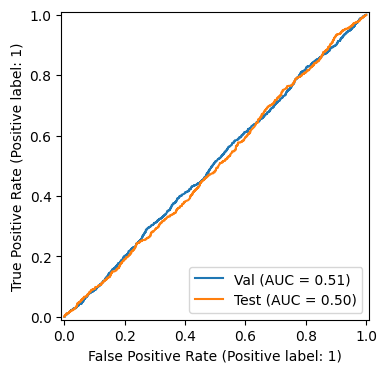

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# ROC curves
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
RocCurveDisplay.from_predictions(y_val, val_proba, name='Val', ax=ax)
RocCurveDisplay.from_predictions(y_test, test_proba, name='Test', ax=ax)
plt.show()